In [1]:
%load_ext autoreload 
%autoreload 2

import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
from torchsummary import summary

import matplotlib.pyplot as plt

from medseg.datasets import PH2Dataset
from medseg.metrics import dice_coefficient, iou_loss, accuracy, sensitivity, specificity, bce_loss
from medseg.models import EncDec, UNetSkip
from medseg.training import train, save_metrics
from medseg.util import Resizer

logging.basicConfig(level=logging.INFO, format='%(name)s: %(message)s')

In [2]:
#logging.getLogger().setLevel(logging.DEBUG)

In [3]:
torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
trainset = PH2Dataset('train')
testset = PH2Dataset('test')
valset = PH2Dataset('validation')

batch_size = 6
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3,
)
val_loader = torch.utils.data.DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=3,
)

## Functions

In [5]:
def plot_metrics(metrics):
    for metric, vec in metrics.items():
        plt.title('Metrics')
        plt.plot(range(1, len(vec)+1), vec, label=metric)
        plt.xticks(range(1, len(vec)+1))
        plt.legend()

## Training - Encoder-Decoder

In [6]:
encdec = EncDec().to(device)
summary(encdec, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 254, 254]           1,792
         MaxPool2d-2         [-1, 64, 127, 127]               0
            Conv2d-3         [-1, 64, 125, 125]          36,928
         MaxPool2d-4           [-1, 64, 62, 62]               0
            Conv2d-5           [-1, 64, 60, 60]          36,928
         MaxPool2d-6           [-1, 64, 30, 30]               0
            Conv2d-7           [-1, 64, 28, 28]          36,928
         MaxPool2d-8           [-1, 64, 14, 14]               0
            Conv2d-9           [-1, 64, 12, 12]          36,928
         Upsample-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 14, 14]          36,928
         Upsample-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 30, 30]          36,928
         Upsample-14           [-1, 64,

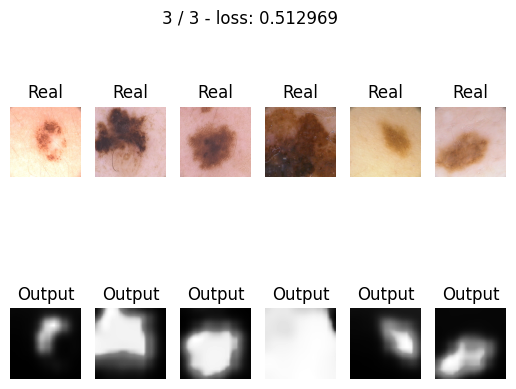

In [7]:
epochs = 3
metrics = train(encdec, torch.optim.Adam(encdec.parameters()), bce_loss, epochs, train_loader, val_loader, device)

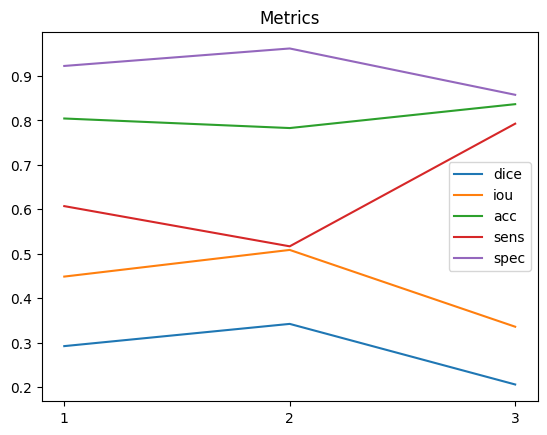

In [8]:
plot_metrics(metrics)

In [9]:
save_metrics('example-metrics-encdec.csv', metrics, overwrite=True)
%cat example-metrics-encdec.csv

epoch,dice,iou,acc,sens,spec
1,0.2920764684677124,0.44858089089393616,0.8043755888938904,0.6071626543998718,0.922658383846283
2,0.3421001732349396,0.5085808038711548,0.7828675508499146,0.5166902542114258,0.9619756937026978
3,0.2057415246963501,0.33573418855667114,0.8366238474845886,0.7927076816558838,0.8577268719673157


## Training - UNet Skip

In [10]:
unetskip = UNetSkip().to(device)
summary(unetskip, (3, 553, 553))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 551, 551]           1,792
            Conv2d-2         [-1, 64, 275, 275]          16,448
            Conv2d-3         [-1, 64, 273, 273]          36,928
            Conv2d-4         [-1, 64, 136, 136]          16,448
            Conv2d-5         [-1, 64, 134, 134]          36,928
            Conv2d-6           [-1, 64, 67, 67]          16,448
            Conv2d-7           [-1, 64, 65, 65]          36,928
            Conv2d-8           [-1, 64, 32, 32]          16,448
            Conv2d-9           [-1, 64, 30, 30]          36,928
  ConvTranspose2d-10           [-1, 64, 60, 60]          16,448
           Conv2d-11           [-1, 64, 58, 58]          73,792
  ConvTranspose2d-12         [-1, 64, 116, 116]          16,448
           Conv2d-13         [-1, 64, 114, 114]          73,792
  ConvTranspose2d-14         [-1, 64, 2

In [11]:
unet_resizer = Resizer(450)

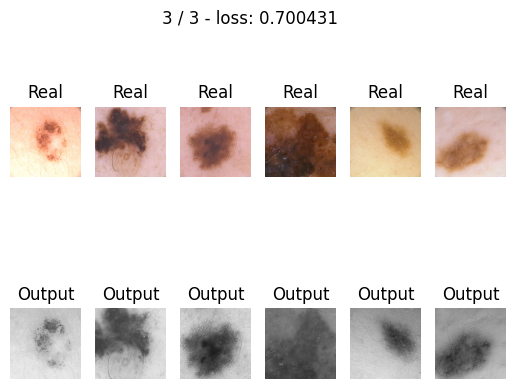

In [12]:
epochs = 3
metrics = train(unetskip, torch.optim.Adam(encdec.parameters()), bce_loss, epochs, train_loader, val_loader, device, resize=unet_resizer)

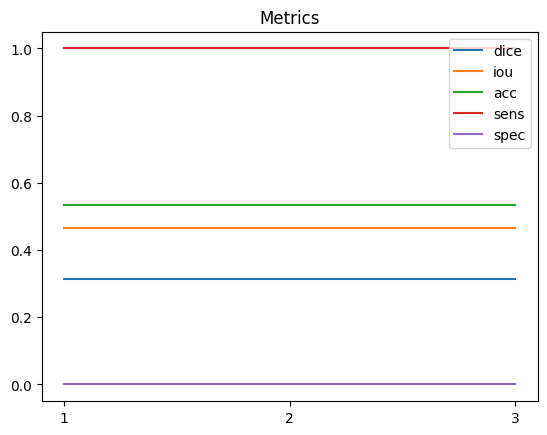

In [13]:
plot_metrics(metrics)

In [14]:
save_metrics('example-metrics-unetskip.csv', metrics, overwrite=True)
%cat example-metrics-unetskip.csv

epoch,dice,iou,acc,sens,spec
1,0.31487521529197693,0.4650702476501465,0.5349296927452087,1.0,0.0
2,0.31487521529197693,0.4650702476501465,0.5349296927452087,1.0,0.0
3,0.31487521529197693,0.4650702476501465,0.5349296927452087,1.0,0.0
